#  프로젝트 : 다양한 OCR모델 비교하기
- Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능
- 용도에 맞게 적절한 것을 선택
- [가정] OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다

# 루브릭 기준
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
   - 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?
   - 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?
   - 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

In [1]:
!mkdir -p ~/aiffel/ocr_python

## GOOGLE CLOUD VISION

### STEP 1) 구글의 파이썬 API 인터페이스 모듈을 아래와 설치합니다.

In [3]:
! pip install --upgrade google-api-python-client
! pip install google-cloud-vision

keras-ocr                     0.8.6
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


카더가든
- 나무
- 우리의 밤을 외워요
- 그대나를일으켜주며

검정치마
- 기다른 만큼 더
- everything
- 하와이 검은 모래

아이유
- 아이와 나의 바다

윤지영
- 우우우린

너드 커넥션 
- 좋은밤 좋은꿈

백예린
- 산책

### STEP 2) Google Cloud Vision API 사용
- [Google Cloud Vision API 키 생성 및 저장하기](https://kimchangheon.tistory.com/166)
  - 인증키: my_google_api_key.json > ~/aiffel/ocr_python에 저장

### STEP 3) API 사용 테스트

In [65]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')
    
    result = ''
    for text in texts[1:]:
        print('\n"{}"'.format(text.description))
        result += (str(text.description) + ' ')
    
    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    
    return result

In [63]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

-rw-r--r-- 1 root root 2341 Sep 21 11:57 /aiffel/aiffel/ocr_python/my_google_api_key.json


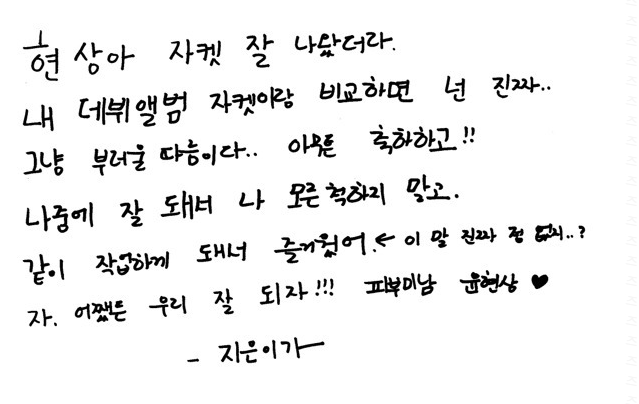

In [66]:
# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
import os
path = os.getenv('HOME')+'/aiffel/ocr_python/03.png'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

Texts:

"현"

"상아"

"자켓"

"잘"

"나왔"

"더라"

"."

"내"

"데뷔"

"앨범"

"자켓"

"이랑"

"비교"

"하면"

"넌"

"진짜"

"."

"그냥"

"부러"

"슬"

"다음"

"이다"

".."

"아른"

"축하"

"하고"

"!!"

"나중에"

"잘"

"돼너"

"나"

"모은"

"혁"

"하지"

"맞고"

"."

"같이"

"작업"

"하게"

"도너"

"즐거웠"

"어"

"."

"이"

"말"

"진짜"

"정"

".."

"?"

"자"

","

"여"

"쨌든"

"우리"

"잘"

"되자"

"!!"

"피부"

"미남"

"현상"

"."

"자은"

"이"

"가"
bounds: (280,338),(310,336),(311,356),(281,358)


'현 상아 자켓 잘 나왔 더라 . 내 데뷔 앨범 자켓 이랑 비교 하면 넌 진짜 . 그냥 부러 슬 다음 이다 .. 아른 축하 하고 !! 나중에 잘 돼너 나 모은 혁 하지 맞고 . 같이 작업 하게 도너 즐거웠 어 . 이 말 진짜 정 .. ? 자 , 여 쨌든 우리 잘 되자 !! 피부 미남 현상 . 자은 이 가 '

# KERAS-OCR
- [keras_ocr 공식문서](https://keras-ocr.readthedocs.io/en/latest/index.html)

In [2]:
! pip list | grep keras-ocr

keras-ocr                     0.8.6
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


- recognize() 는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출
- 인식기가 각 박스로부터 문자를 인식

In [37]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
#     'https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Naturalis_Biodiversity_Center_-_RMNH.MOL.149794_-_Nerita_signata_Lamarck%2C_1822_-_Neritidae_-_Mollusc_shell.jpeg/800px-Naturalis_Biodiversity_Center_-_RMNH.MOL.149794_-_Nerita_signata_Lamarck%2C_1822_-_Neritidae_-_Mollusc_shell.jpeg'
    os.getenv('HOME')+'/aiffel/ocr_python/03.png',
    os.getenv('HOME')+'/aiffel/ocr_python/04.jpg'
#     'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
#     'https://upload.wikimedia.org/wikipedia/commons/e/e8/FseeG2QeLXo.jpg',
#     'https://upload.wikimedia.org/wikipedia/commons/b/b4/EUBanana-500x112.jpg'    
]

images = [ keras_ocr.tools.read(url) for url in image_urls]

In [38]:
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

In [53]:
result = ''
for i in range(len(prediction_groups[0][0])):
    result += ( str(prediction_groups[0][0][i][0]) + ' ')
print(result)

littyh z olktoo phh zizvts upoidl l zhoke calot lh soor oren choofet ulri 21c diss dzz2l lf shei 2z lfjol gay e z yvf dl zmsteol chlst zlfoml el cokts igdlyy ilzeh z iel one zf zlolzh 


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


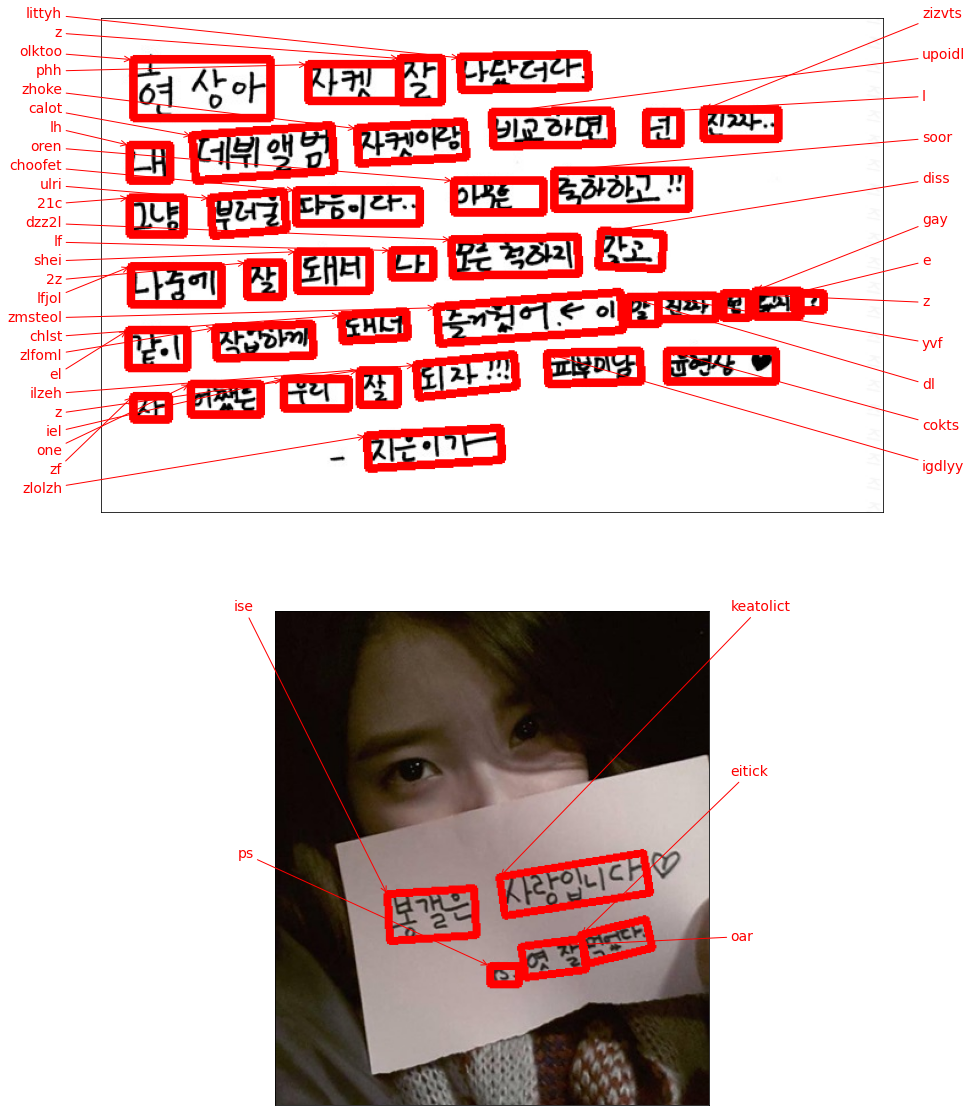

In [39]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 테서랙트 써보기

In [17]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 0 not upgraded.
Need to get 7,031 kB of archives.
After this operation, 22.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libopenjp2-7 amd64 2.3.0-2build0.18.04.1 [145 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 liblept5 amd64 1.75.3-3 [929 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract4 amd64 4.00~git2288-10f4998a-2 [1,163 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:5 http://archive.ubuntu.c

In [19]:
! sudo apt install tesseract-ocr-kor -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-kor
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,050 kB of archives.
After this operation, 1,693 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-kor all 4.00~git24-0e00fe6-1.2 [1,050 kB]
Fetched 1,050 kB in 1s (1,135 kB/s)          
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline

78Selecting previously unselected package tesseract-ocr-kor.
(Reading database ... 73165 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-kor_4.00~git24-0e00fe6-1.2_all.deb ...
7Progress: [  0%] [.................

In [7]:
! pip list | grep pytesseract
! pip install pytesseract

pytesseract                   0.3.7
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [82]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output', lan = 'eng'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang=lan,    # 'eng', 'kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [22]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/12.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
/aiffel/aiffel/ocr_python/0024.png
/aiffel/aiffel/ocr_python/0025.png
/aiffel/aiffel/ocr_python/0026.png


In [83]:
def recognize_images(cropped_image_path_list, lan = 'eng'):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lan,    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
        result += (str(recognized_data['text'])[:-2] + ' ')
    print("Done")
    return result

In [58]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

가장

크


광

은

한

번도

실

패

하즈

| 않

음

(0)

| 아니라

실

패

할


마다

다ㅅ

| 일

0

서

는

데

여

| 있다.

Done


'가장 크  광 은 한 번도 실 패 하즈 | 않 음 (0) | 아니라 실 패 할  마다 다ㅅ | 일 0 서 는 데 여 | 있다. '

## Step1. 검증용 데이터셋 준비
- OCR의 성능에 영향을 미치는 요인들: 텍스트의 모양과 크기, 배치, 노이즈 등
- 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

- 가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
- 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 

In [79]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
kor_img_path = [
    os.getenv('HOME')+'/aiffel/ocr_python/kor_01.png',
    os.getenv('HOME')+'/aiffel/ocr_python/kor_02.png',
    os.getenv('HOME')+'/aiffel/ocr_python/kor_03.jpg',
    os.getenv('HOME')+'/aiffel/ocr_python/kor_04.png'
]
eng_img_path = [
    os.getenv('HOME')+'/aiffel/ocr_python/eng_01.jpg',
    os.getenv('HOME')+'/aiffel/ocr_python/eng_02.jpg',
    os.getenv('HOME')+'/aiffel/ocr_python/eng_03.jpg',
    
]

## 영어(google, keras, tesseract)

In [84]:
goog = []
kera = []
tess = []

keras_img = []
keras_prediction_groups = []
for path in eng_img_path :
    #google
    print("################# GOOGLE ##################")
    goog.append(detect_text(path))

    #keras
    print("################# KERAS ##################")
    images = keras_ocr.tools.read(path)
    prediction_groups = pipeline.recognize([path])
    keras_img.append(images)
    keras_prediction_groups.append(prediction_groups)
    
    result = ''
    for i in range(len(prediction_groups[0])):
        result += ( str(prediction_groups[0][i][0]) + ' ')
    kera.append(result)
    
    #tesseract
    print("################# TESSERACT ##################")
    cropped_image_path_list = crop_word_regions(path, work_dir, lan = 'eng')
    tess.append(recognize_images(cropped_image_path_list, lan = 'eng'))

################# GOOGLE ##################
Texts:

"MEDIA"

"INTERNET"

"RADIO"

"TELEVISION"

"NEWSPAPERS"

"MAGAZINES"
bounds: (48,724),(494,624),(511,699),(65,799)
################# KERAS ##################
################# TESSERACT ##################
/aiffel/aiffel/ocr_python/0000.png
on

Done
################# GOOGLE ##################
Texts:

"LOVE"

"IS"

"COMPOSED"

"OF"

"A"

"SINGLE"

"SOUL"

"INHABITING"

"TWO"

"BODIES,"

"-"

"Aristotle"
bounds: (175,308),(225,308),(225,320),(175,320)
################# KERAS ##################
################# TESSERACT ##################
/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr

## 한국어(google, tesseract) 

In [94]:
kor_goog = []
kor_tess = []
for path in kor_img_path :
    #google
    print("################# GOOGLE ##################")
    kor_goog.append(detect_text(path))

    #keras: 불가
    
    #tesseract
    print("################# TESSERACT ##################")
    cropped_image_path_list = crop_word_regions(path, work_dir, lan = 'kor')
    kor_tess.append(recognize_images(cropped_image_path_list, lan = 'kor'))

################# GOOGLE ##################
Texts:

"게으른"

"행동"

"에"

"대해"

"하늘"

"이"

"주는"

"벌"

"은"

"두가지"

"이다"

"."

"하나"

"는"

"자신"

"의"

"실패"

"이고"

","

"또"

"다른"

"하나"

"는"

"내가"

"하지"

"않은"

"일"

"을"

"해낸"

"옆"

"사람"

"의"

"성공"

"이다"

"."

":"

"줄스"

"레나드"

"#"

"오늘"

"부터"

"열정"

"맨"

"#"

"1"

"일"

"1"

"명언"
bounds: (431,422),(447,422),(447,443),(431,443)
################# TESSERACT ##################
/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python

## Step3. 테스트 결과 정리
- 모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리
- 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

- 영어: google, keras, tesseract

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img

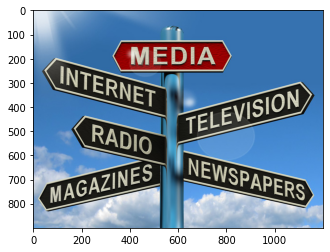

################# GOOGLE ##################
MEDIA INTERNET RADIO TELEVISION NEWSPAPERS MAGAZINES 
################# KERAS ##################
media internet television radio newspapers magazines 
################# TESSERACT ##################
on 


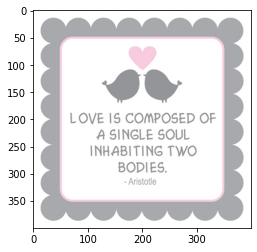

################# GOOGLE ##################
LOVE IS COMPOSED OF A SINGLE SOUL INHABITING TWO BODIES, - Aristotle 
################# KERAS ##################
a love is composed of single soul a inhabiting two bodies aristotle 
################# TESSERACT ##################
@QOod LOVE Oo COMPOSED OF A SINGLE SOUL INHABITING TWO BODIES. i Aristotie ones . 


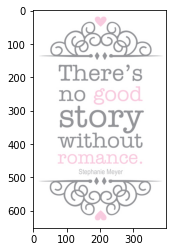

################# GOOGLE ##################
There's no good story without romance. Stephanie Meyer 
################# KERAS ##################
theres good no story without romance stephanie meyer 
################# TESSERACT ##################
 There’s ate Sood StOry without POTIGALLCe. stepnanie Vieyer & © fo) 


In [92]:
for idx, path in enumerate(eng_img_path):
    image = img.imread(path)
    plt.imshow(image)
    plt.show()
    print("################# GOOGLE ##################")
    print(goog[idx])
    print("################# KERAS ##################")
    print(kera[idx])
    print("################# TESSERACT ##################")
    print(tess[idx])

- keras

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


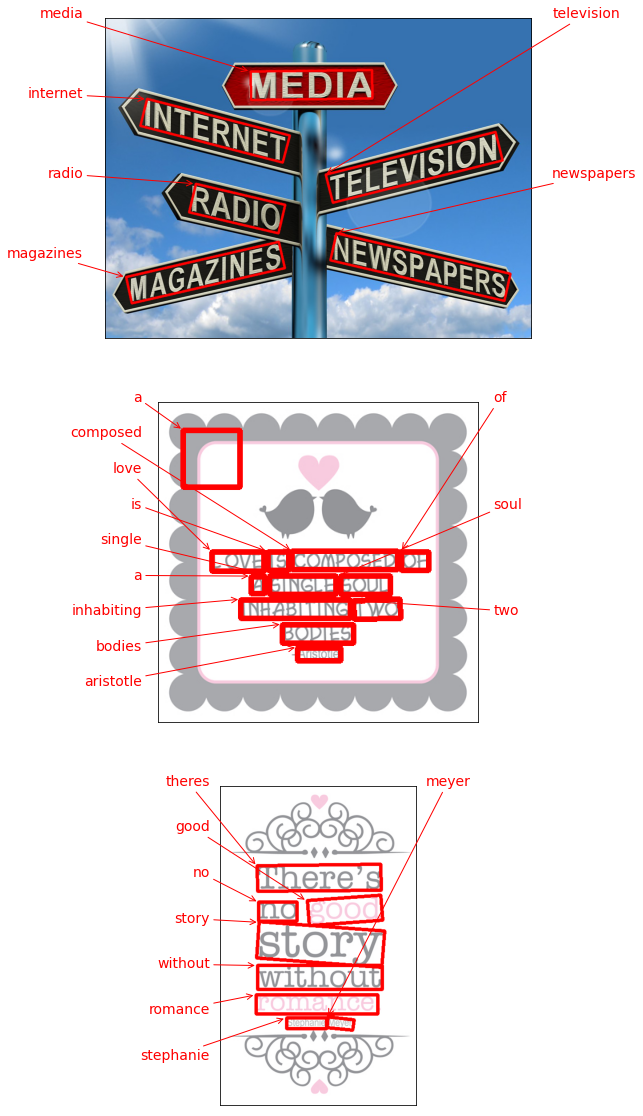

In [86]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(keras_img), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_img[idx], 
                                    predictions=keras_prediction_groups[idx][0], ax=ax)

- 한국어: google, tesseract

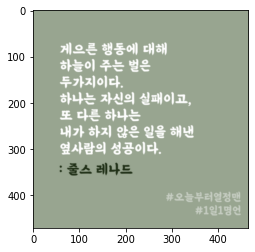

################# GOOGLE ##################
게으른 행동 에 대해 하늘 이 주는 벌 은 두가지 이다 . 하나 는 자신 의 실패 이고 , 또 다른 하나 는 내가 하지 않은 일 을 해낸 옆 사람 의 성공 이다 . : 줄스 레나드 # 오늘 부터 열정 맨 # 1 일 1 명언 
################# TESSERACT ##################
제으른 행동 1 | 대해 하늘이 주는 | 2 1 구 두가지 이 다. 7 1 의 실 패 0 고 ㄴ』 개도 나는 6 쪼751 | 기 존그 일 을 1 여기 람 의 5, 공ㅇ 12! ㆍ 1 ㄴㄴ - 1 그 1, 정 이, ㆍ 개 | 1 1 구 트 , 


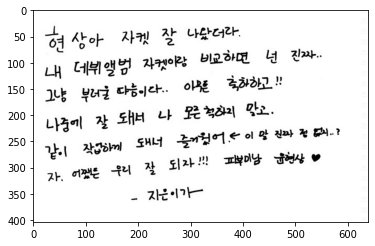

################# GOOGLE ##################
현 상아 자켓 잘 나왔 더라 . 내 데뷔 앨범 자켓 이랑 비교 하면 넌 진짜 . 그냥 부러 슬 다음 이다 .. 아른 축하 하고 !! 나중에 잘 돼너 나 모은 혁 하지 맞고 . 같이 작업 하게 도너 즐거웠 어 . 이 말 진짜 정 .. ? 자 , 여 쨌든 우리 잘 되자 !! 피부 미남 현상 . 자은 이 가 
################# TESSERACT ##################
셔 산 아 자케 식" 나 스 1. [가 ㄴㄴ 위 애범  우아 ~ 크 자 개개 () 앙 그 | 분 하떤 넌 진2자.. 그냥 배 너그  우아 ~ 크 .삐 『근이 『ㄴ. . 아옥은 줄까  우아 ~ 크 하근. 4 나 성이 | 장 돼너 나 수  우아 ~ 크 적 지그 | 2 . 난, | 자 ~ 17) 도 ㄱ  우아 ~ 크 -- ? 4, 건 71 < 이 강 진자 선 ^, 272. 0 써온  우아 ~ 크 -우리 자 디자: 1)  우아 ~ 크 ㅠ뿌미 냥  우아 ~ 크 굽전상  우아 ~ 크 0 0 2| ㅜ- 7 


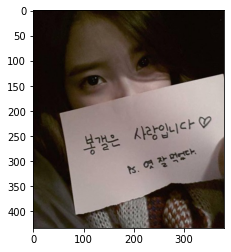

################# GOOGLE ##################
봉갤 은 사랑 입니다 s . 엿 잘 먹었다 . 
################# TESSERACT ##################
 


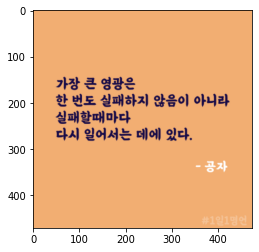

################# GOOGLE ##################
가장 큰 영광 은 한 번도 실패 하지 않음 이 아니라 실패 할 때 마다 다시 일어서 는 데 에 있다 . - 공자 # 1 일 1 명언 
################# TESSERACT ##################
가장 크  광 은 한 번도 실 패 하즈 | 않 음 (0) | 아니라 실 패 할  마다 다ㅅ | 일 0 서 는 데 여 | 있다. 


In [95]:
for idx, path in enumerate(kor_img_path):
    image = img.imread(path)
    plt.imshow(image)
    plt.show()
    print("################# GOOGLE ##################")
    print(kor_goog[idx])
    print("################# TESSERACT ##################")
    print(kor_tess[idx])

## Step4. 결과 분석과 결론 제시

- 해당 서비스는 시각장애인을 위해 글 또는 이미지로 부터 글자를 읽어 추출해주는 서비스다(해당 텍스트는 이후 TTS를 이용해 읽을 수 있음). 위 3가지 API의 성능 상 완벽한 추출은 어렵겠지만 사람의 수고를 덜어줄 정도는 된다. (추가적으로 시각장애인에게 스마트 글래스를 착용하면 내가 바라보는 방향에 있는 간판을 읽어주거나, 얼마나 앞쪽에 장애물이 있는지 알려주는 기능을 추가할 수도 있다.)
- 평가기준
  - **한국어** 내용을 지원하기 위해 `GOOGLE` 또는 `TESSERACT API`를 사용하기로 한다.
  - 이때 일반적인 사진에 등장하는 텍스트도 읽으려면 `GOOGLE API`를 사용해야만 한다.
  - 평가기준은 글자를 인식하는 정확도이다. (입력과 출력이 같은 비율)
  - GOOGLE API에 따르면 폰트로 작성된 내용은 대부분 정확히 읽어주고, 이미지에 나와있는 내용도 인간이 인식하는 수준으로 이해할 정도의 내용을 읽어준다. 
    - 가장 큰 영광은 한번도 실패하지 않음이 아니라 실패할 때 마다 다시 일어서는 데에 있다. 라는 텍스트 이미지는 100% 완벽한 인식률을 보여준다.

# 회고

- 이번 노드는 딥러닝 레이어를 공부하던 지금까지의 내용과 달리 API를 가져와서 사용해보는 노드였다.
- 추석 연휴 중이라 황급히 작성해서 제출한 감이 없지 않아 있지만, 충분히 흥미로운 주제였고, 실제로 스캔한 책들을 차례대로 넣어 텍스트 파일로 변형할 때도 활용할 수 있을 것 같다.
- 해당 노드를 분석하면서, 이미지 인식을 통해 장애인 지원을 꾀할 수 있는 방법이 무궁무진 할 것 같다. 특히 시각을 대신하는 분야는 CV를 통해 아주 높은 활용도로 가능할 것 같다. 이전에도 이런 이야기를 썼던 것 같은데, 딥러닝을 하는 모든 사람은 결국 돌아돌아 모든 분야를 다 건드리게 된다는데, 나도 그렇지 않을까.